**Library**

In [34]:
import os
# Python default libraries
from pathlib import Path
import time
import base64
# processing images
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from io import BytesIO
# visualising the data 
import matplotlib.pyplot as plt
# masked or not masked classification
import tensorflow as tf
#for js script scroll video
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import io
import html
import time
from PIL import Image
from google.colab.patches import cv2_imshow
import PIL

#tf library
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

**Global Variable**

In [2]:
# Max enabled image width is set as 300. If greater we will resize the input images 
BASEWIDTH = 600
MASKED_COLOR = '#00b189'
NOT_MASKED_COLOR = '#365abd'

ROOT_DIR = os.path.join(os.path.dirname(os.path.abspath(os.curdir)),'content')
FONT_TTF_LOC = Path(ROOT_DIR) / 'data' / 'fonts' / 'Arvo-Regular.ttf'

FONT_TTF_LOC.mkdir(exist_ok = True,parents = True)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!tar -xvf /content/drive/MyDrive/face_reconigition_mask/data.tar.gz -C /content

In [5]:
!git clone https://github.com/gopinath-balu/computer_vision

Cloning into 'computer_vision'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 13 (delta 0), reused 6 (delta 0), pack-reused 7
Unpacking objects: 100% (13/13), done.


**LoadModel**

In [6]:
classifier_dir = Path(ROOT_DIR) / 'data' / 'classifier_model_weights'
classifier_mask = tf.keras.models.load_model(classifier_dir / 'best.h5')

In [7]:
config_path = "/content/computer_vision/CAFFE_DNN/deploy.prototxt.txt"
weight_path = "/content/computer_vision/CAFFE_DNN/res10_300x300_ssd_iter_140000.caffemodel"

FACEnet = cv2.dnn.readNet(config_path,weight_path)

**Picture**

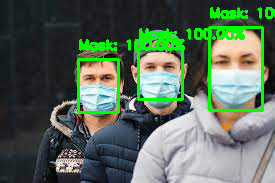

-1

In [31]:
image_path = "/content/face_mask_sample2.jpeg"
image = cv2.imread(image_path)

orig = image.copy()

(h,w) = image.shape[:2]

blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),(104.0, 177.0, 123.0))
FACEnet.setInput(blob)
detections = FACEnet.forward()

for i in range(detections.shape[2]):
    confidence = detections[0,0,i,2]
    if confidence > 0.5:
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
      
        (startX, startY) = (max(0, startX), max(0, startY))
        (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
      
        face = image[startY:endY, startX:endX]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = cv2.resize(face, (112, 112))

        face = img_to_array(face)
        face = preprocess_input(face)
        face = np.expand_dims(face, axis=0)

        val = classifier_mask.predict(face)[0][0]
        
        if val > 0.5:
           label = "Mask"
        else:
           label = "No Mask"
        # label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
        
        label = "{}: {:.2f}%".format(label, val * 100)
        cv2.putText(image, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

cv2_imshow(image)
cv2.waitKey(0)

**Streaming**

**HelperFunction**

In [39]:
def start_input():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 512, 512);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 512; //video.videoWidth;
      captureCanvas.height = 512; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function takePhoto(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def take_photo(label, img_data):
    data = eval_js('takePhoto("{}", "{}")'.format(label, img_data))
    return data

In [37]:
def js_reply_to_image(js_reply):
    """
    input: 
          js_reply: JavaScript object, contain image from webcam

    output: 
          image_array: image array RGB size 512 x 512 from webcam
    """
    jpeg_bytes = base64.b64decode(js_reply['img'].split(',')[1])
    image_PIL = Image.open(io.BytesIO(jpeg_bytes))
    image_array = np.array(image_PIL)

    return image_array

def bbox_to_bytes(bbox_array):
    """
    Params:
            bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
    Returns:
          bytes: Base64 image byte string
    """
    # convert array into PIL image
    bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
    iobuf = io.BytesIO()
    # format bbox into png for return
    bbox_PIL.save(iobuf, format='png')
    # format return string
    bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

    return bbox_bytes

**Process**

In [ ]:
start_input()

label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = take_photo(label_html, bbox)
    # js_reply = take_photo(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    image = js_reply_to_image(js_reply)

    w,h = image.shape[:2]

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # # grayscale image for face detection
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # # get face region coordinates
    # faces = face_cascade.detectMultiScale(gray)
    # # get face bounding box for overlay
    # for (x,y,w,h) in faces:
    #   bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)


    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),(104.0, 177.0, 123.0))
    FACEnet.setInput(blob)
    detections = FACEnet.forward()
    for i in range(detections.shape[2]):
        confidence = detections[0,0,i,2]
        if confidence > 0.5:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
          
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
          
            face = image[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (112, 112))

            face = img_to_array(face)
            face = preprocess_input(face)
            face = np.expand_dims(face, axis=0)

            val = classifier_mask.predict(face)[0][0]
            
            if val > 0.5:
              label = "Mask"
            else:
              label = "No Mask"
            # label = "Mask" if mask > withoutMask else "No Mask"
            color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
            
            label = "{}: {:.2f}%".format(label, val * 100)
            bbox_array = cv2.putText(bbox_array, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
            bbox_array = cv2.rectangle(bbox_array, (startX, startY), (endX, endY), color, 2)
    
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

    if cv2.waitKey(1) & 0xFF == ord('q'):
      break